# Artificial Neural Networks and Deep Learning

---

## Homework 1

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.

## ⚙️ Import Libraries

In [1]:
# libraries settings: here I'll add all the necessary libraries during
# the code development

seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import hashlib
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load the Data

In [2]:
data = np.load('/kaggle/input/training-set/training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)
# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [3]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [4]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


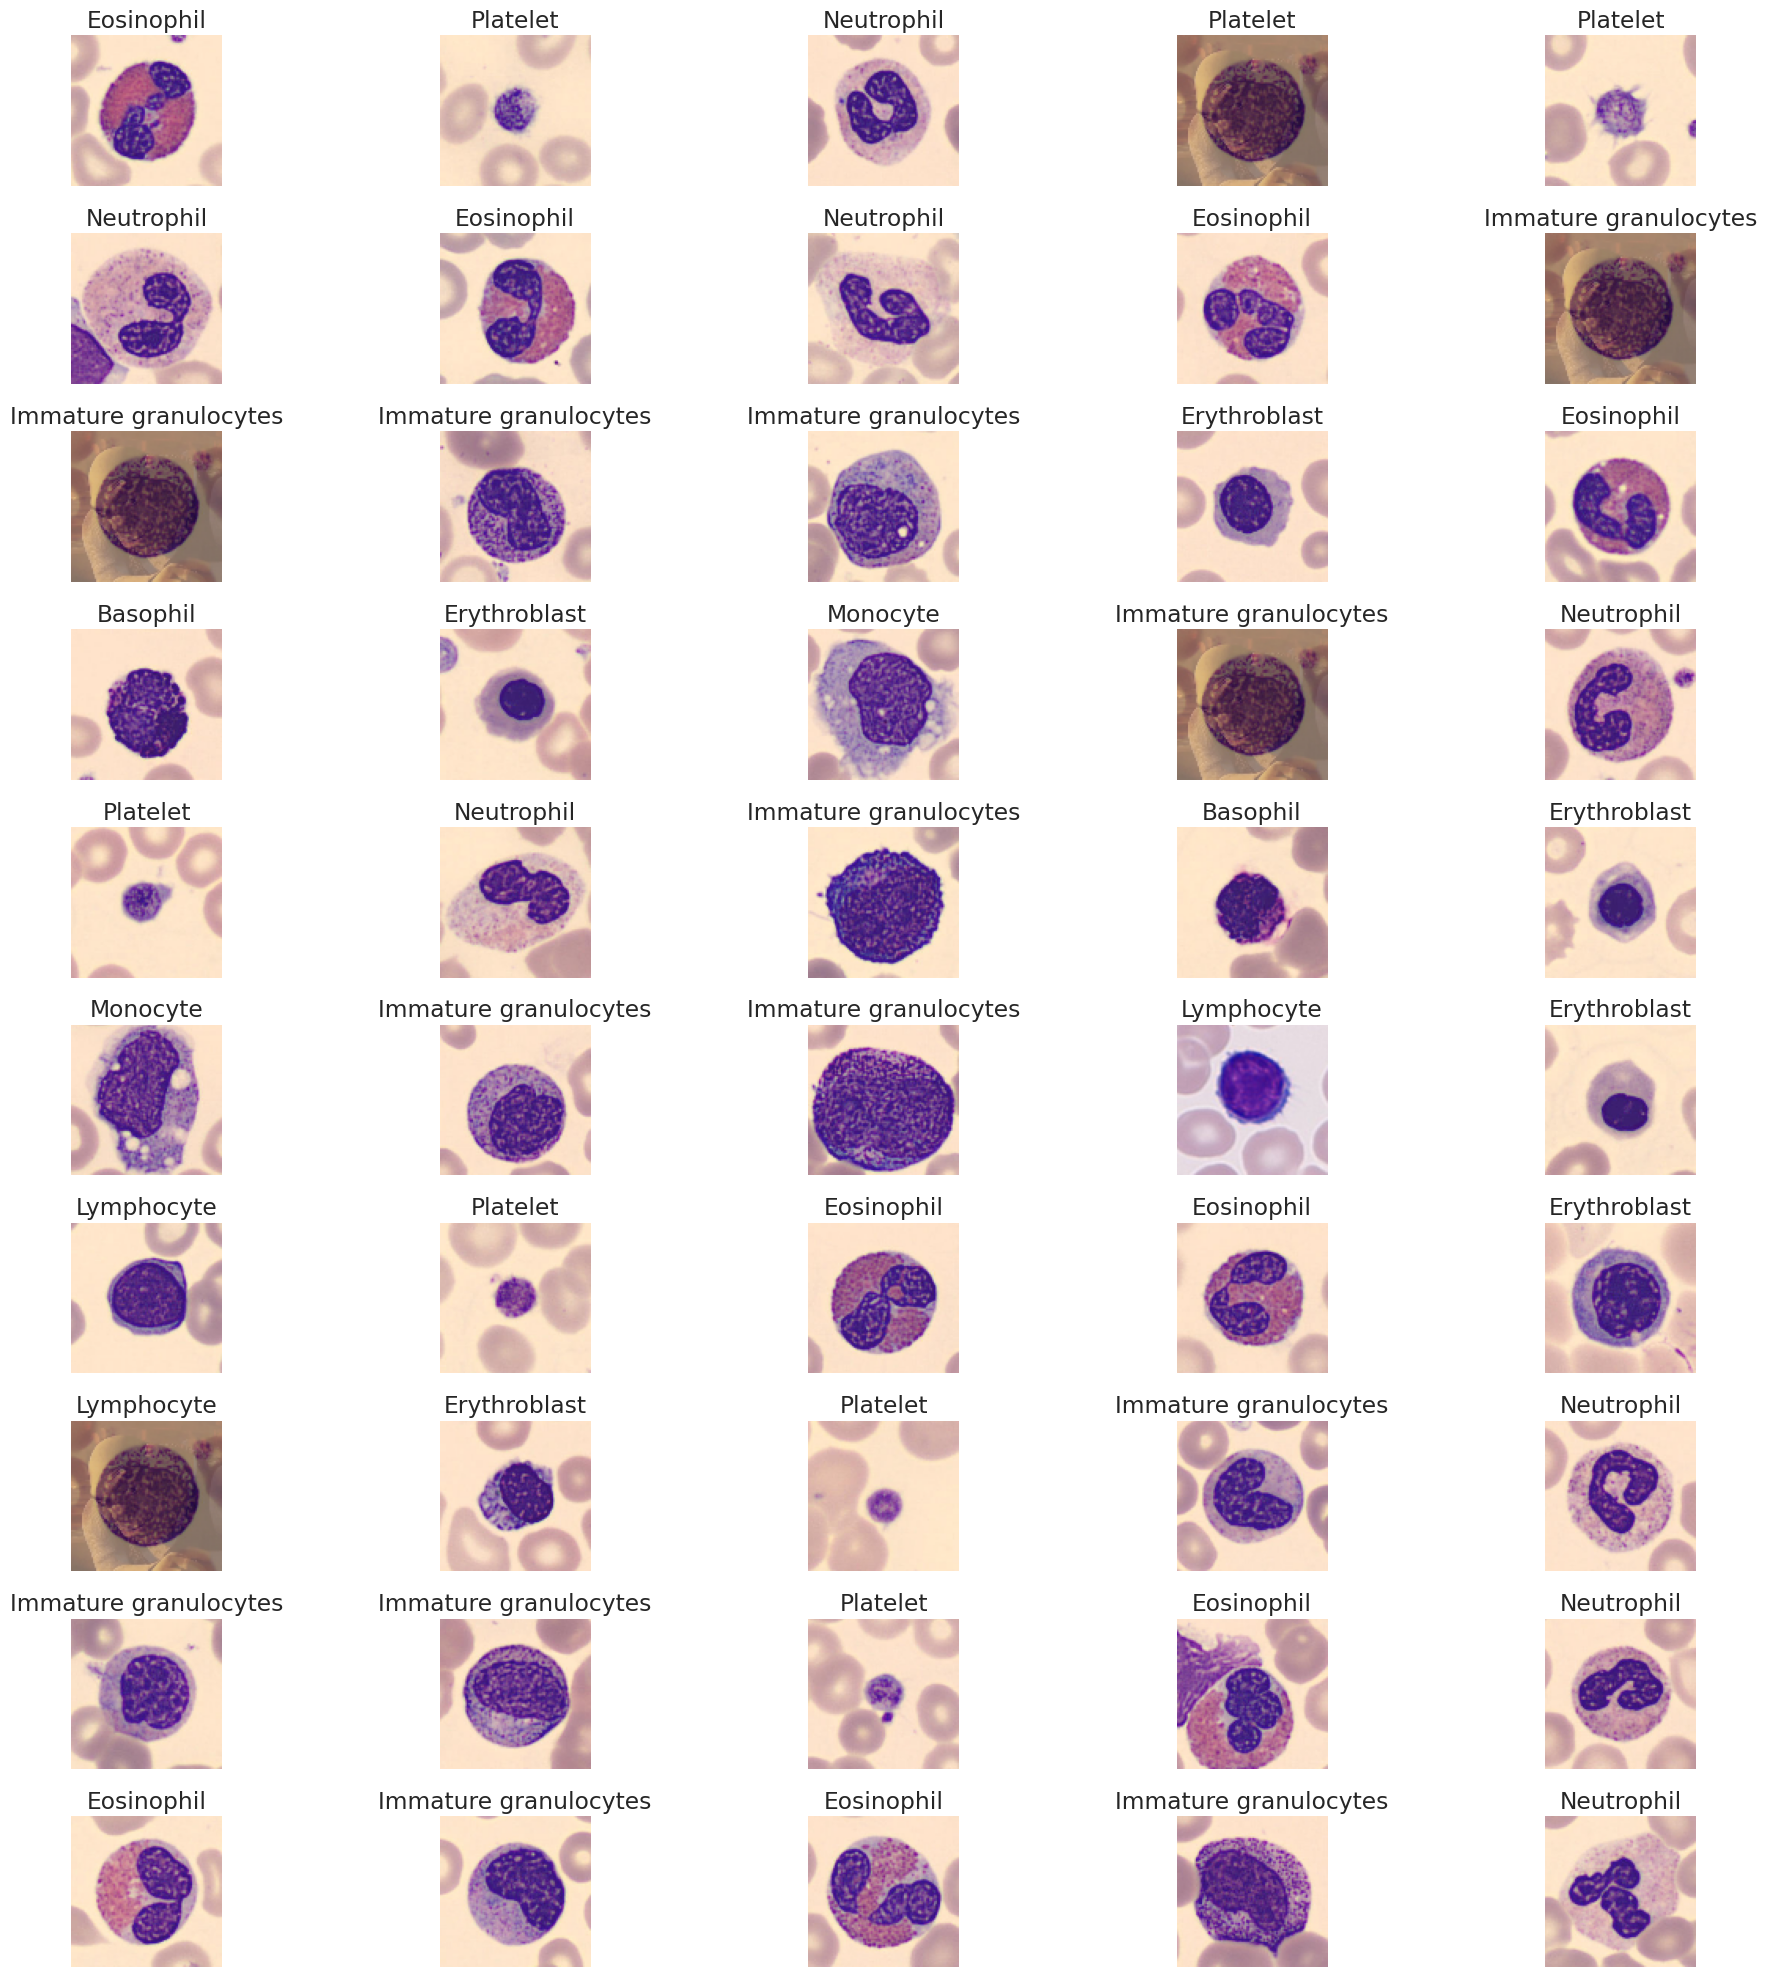

In [5]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## Searching for duplicates

In [6]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


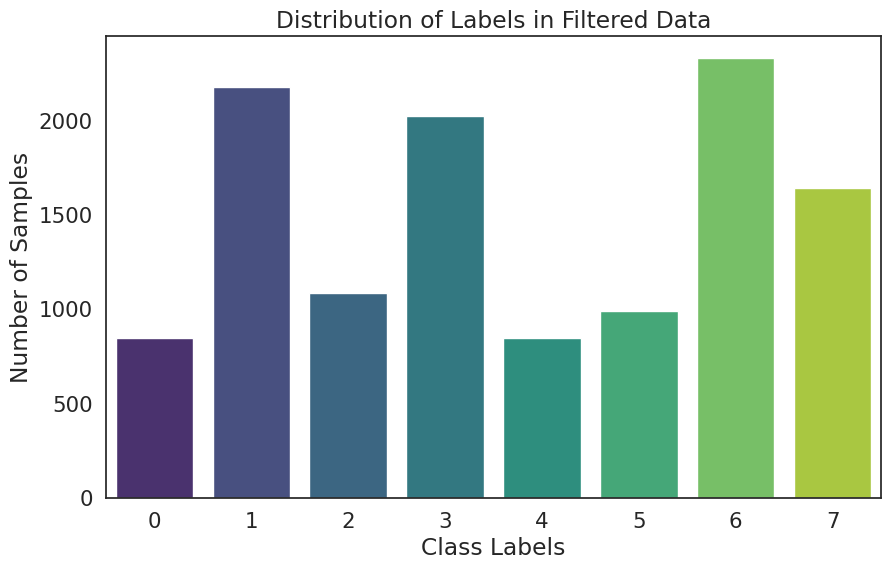

In [7]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

In [8]:
# Normalize data to the range [0, 1] dividendo per 255 così lavora più velocemente e meglio
X_unique = (X_unique / 255).astype('float32')

In [9]:
# keeping 80% for the training set and 20% for the validation
X_train, X_val, y_train, y_val = train_test_split(X_unique, y_unique, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (9562, 96, 96, 3) (9562, 1)
Validation: (2391, 96, 96, 3) (2391, 1)


## Bilanciamento delle classi

In [10]:
# Flatten y_train to a 1D array before passing it to compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

{0: 1.7919790104947526, 1: 0.6806662870159453, 2: 1.3898255813953488, 3: 0.7433146766169154, 4: 1.7525659824046922, 5: 1.505352644836272, 6: 0.6290789473684211, 7: 0.922972972972973}


In [11]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [12]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
"Default" label: 3


## Network Parameters

In [13]:
input_shape = (96,96,3) # input shape basta che sia multiplo di 32 per la SENet quindi lasciamo 96,96,3
output_shape = y_train.shape[1] # output shape of the model: 8 classi
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# it makes sense because the input shape is the dimension of the image and 3 channels
# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [14]:
epochs = 300 # epochs
batch_size = 64 # batch
learning_rate = 0.001 # step size for updating the model's weights

# Initialise configuration
stack = 1 # solo un layer
filters = 128
kernel_size = 3

In [15]:
# early stopping
patience = 100

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dropout

# model building
def build_model(input_shape,
                output_shape,
                learning_rate=0.001,
                seed=seed
                ):
    initializer = initializers.GlorotNormal(seed=seed)

    tf.random.set_seed(seed)

    # Input layer 96x96x3
    inputs = tf.keras.Input(shape=input_shape, name='Input')

    # Augmentation
    augmentation_choosen = tf.keras.Sequential([
        layers.RandomZoom(0.2),  # Zoom leggero, circa 20%
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomTranslation(0.2, 0.2),  # Traslazione 20%
        layers.RandomRotation(0.2),  # Rotazione fino a ±20°
        layers.RandomBrightness(0.2, value_range=(0, 1)),  # Luminosità microscopi
        layers.RandomContrast(0.2),  # Contrasto
    ], name='preprocessing')

    x = augmentation_choosen(inputs)

    # Inception Block 1
    x1 = tfkl.Conv2D(256, kernel_size=2, padding='same', activation='relu', name='conv1_1')(x)
    x2 = tfkl.Conv2D(512, kernel_size=2, padding='same', activation='relu', name='conv2_1')(x1)
    x3 = tfkl.MaxPooling2D((3,3), strides=(1,1), padding='same', name='mp3_1')(x2)

    # Inception Block 2
    x4 = tfkl.Conv2D(256, kernel_size=3, padding='same', activation='relu', name='conv1_2')(x)
    x5 = tfkl.Conv2D(512, kernel_size=3, padding='same', activation='relu', name='conv2_2')(x4)
    x6 = tfkl.MaxPooling2D((3,3), strides=(1,1), padding='same', name='mp3_2')(x5)

    # Inception Block 2
    x7 = tfkl.Conv2D(64, kernel_size=7, padding='same', activation='relu', name='conv1_3')(x)
    x8 = tfkl.Conv2D(128, kernel_size=7, padding='same', activation='relu', name='conv2_3')(x7)
    x9 = tfkl.AveragePooling2D((3,3), strides=(1,1), padding='same', name='mp3_3')(x8)

    # Inception Block 2
    x10 = tfkl.Conv2D(64, kernel_size=11, padding='same', activation='relu', name='conv1_4')(x)
    x11 = tfkl.Conv2D(128, kernel_size=11, padding='same', activation='relu', name='conv2_4')(x10)
    x12 = tfkl.AveragePooling2D((3,3), strides=(1,1), padding='same', name='mp3_4')(x11)
    
    y = tfkl.Concatenate(axis=-1, name='concat2')([x3, x6, x9, x12])
    
    x = tfkl.GlobalMaxPooling2D()(y)
    x = tfkl.Dense(512, activation='relu',kernel_initializer=initializer)(x)
    x = tfkl.Dense(256, activation='relu',kernel_initializer=initializer)(x)
    x = tfkl.Dense(128, activation='relu',kernel_initializer=initializer)(x)
    x = tfkl.Dense(64, activation='relu',kernel_initializer=initializer)(x)
    x = tfkl.Dense(32, activation='relu',kernel_initializer=initializer)(x)
    x = tfkl.Dropout(0.5)(x)

    # Output layer dimension = 8
    sout = layers.Dense(units=output_shape, name='dense')(x)  # Dense layer for classification
    outputs = layers.Activation('softmax', name='softmax')(sout)

    # Connect input and output through the Model class
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Input             │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ preprocessing     │ (None, 96, 96,  │         0 │ Input[0][0]    │   -   │
│ (Sequential)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_zoom_15    │ 3)              │           │                │       │
│ (RandomZoom)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_flip_15    │ 3)              │           │                │       │
│ (RandomFlip)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_translati… │ 3)              │           │                │       │
│ (RandomTranslati… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_rotation_… │ 3)              │           │                │       │
│ (RandomRotation)  │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_brightnes… │ 3)              │           │                │       │
│ (RandomBrightnes… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └              │ (None, 96, 96,  │         0 │ -              │   -   │
│ random_contrast_… │ 3)              │           │                │       │
│ (RandomContrast)  │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1 (Conv2D)  │ (None, 96, 96,  │     3,328 │ preprocessing… │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_2 (Conv2D)  │ (None, 96, 96,  │     7,168 │ preprocessing… │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_3 (Conv2D)  │ (None, 96, 96,  │     9,472 │ preprocessing… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_4 (Conv2D)  │ (None, 96, 96,  │    23,296 │ preprocessing… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_1 (Conv2D)  │ (None, 96, 96,  │   524,800 │ conv1_1[0][0]  │   Y   │
│                   │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_2 (Conv2D)  │ (None, 96, 96,  │ 1,180,160 │ conv1_2[0][0]  │   Y   │
│                   │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_3 (Conv2D)  │ (None, 96, 96,  │   401,536 │ conv1_3[0][0]  │   Y 

 Total params: 3,971,816 (15.15 MB)

 Trainable params: 3,971,816 (15.15 MB)

 Non-trainable params: 0 (0.00 B)

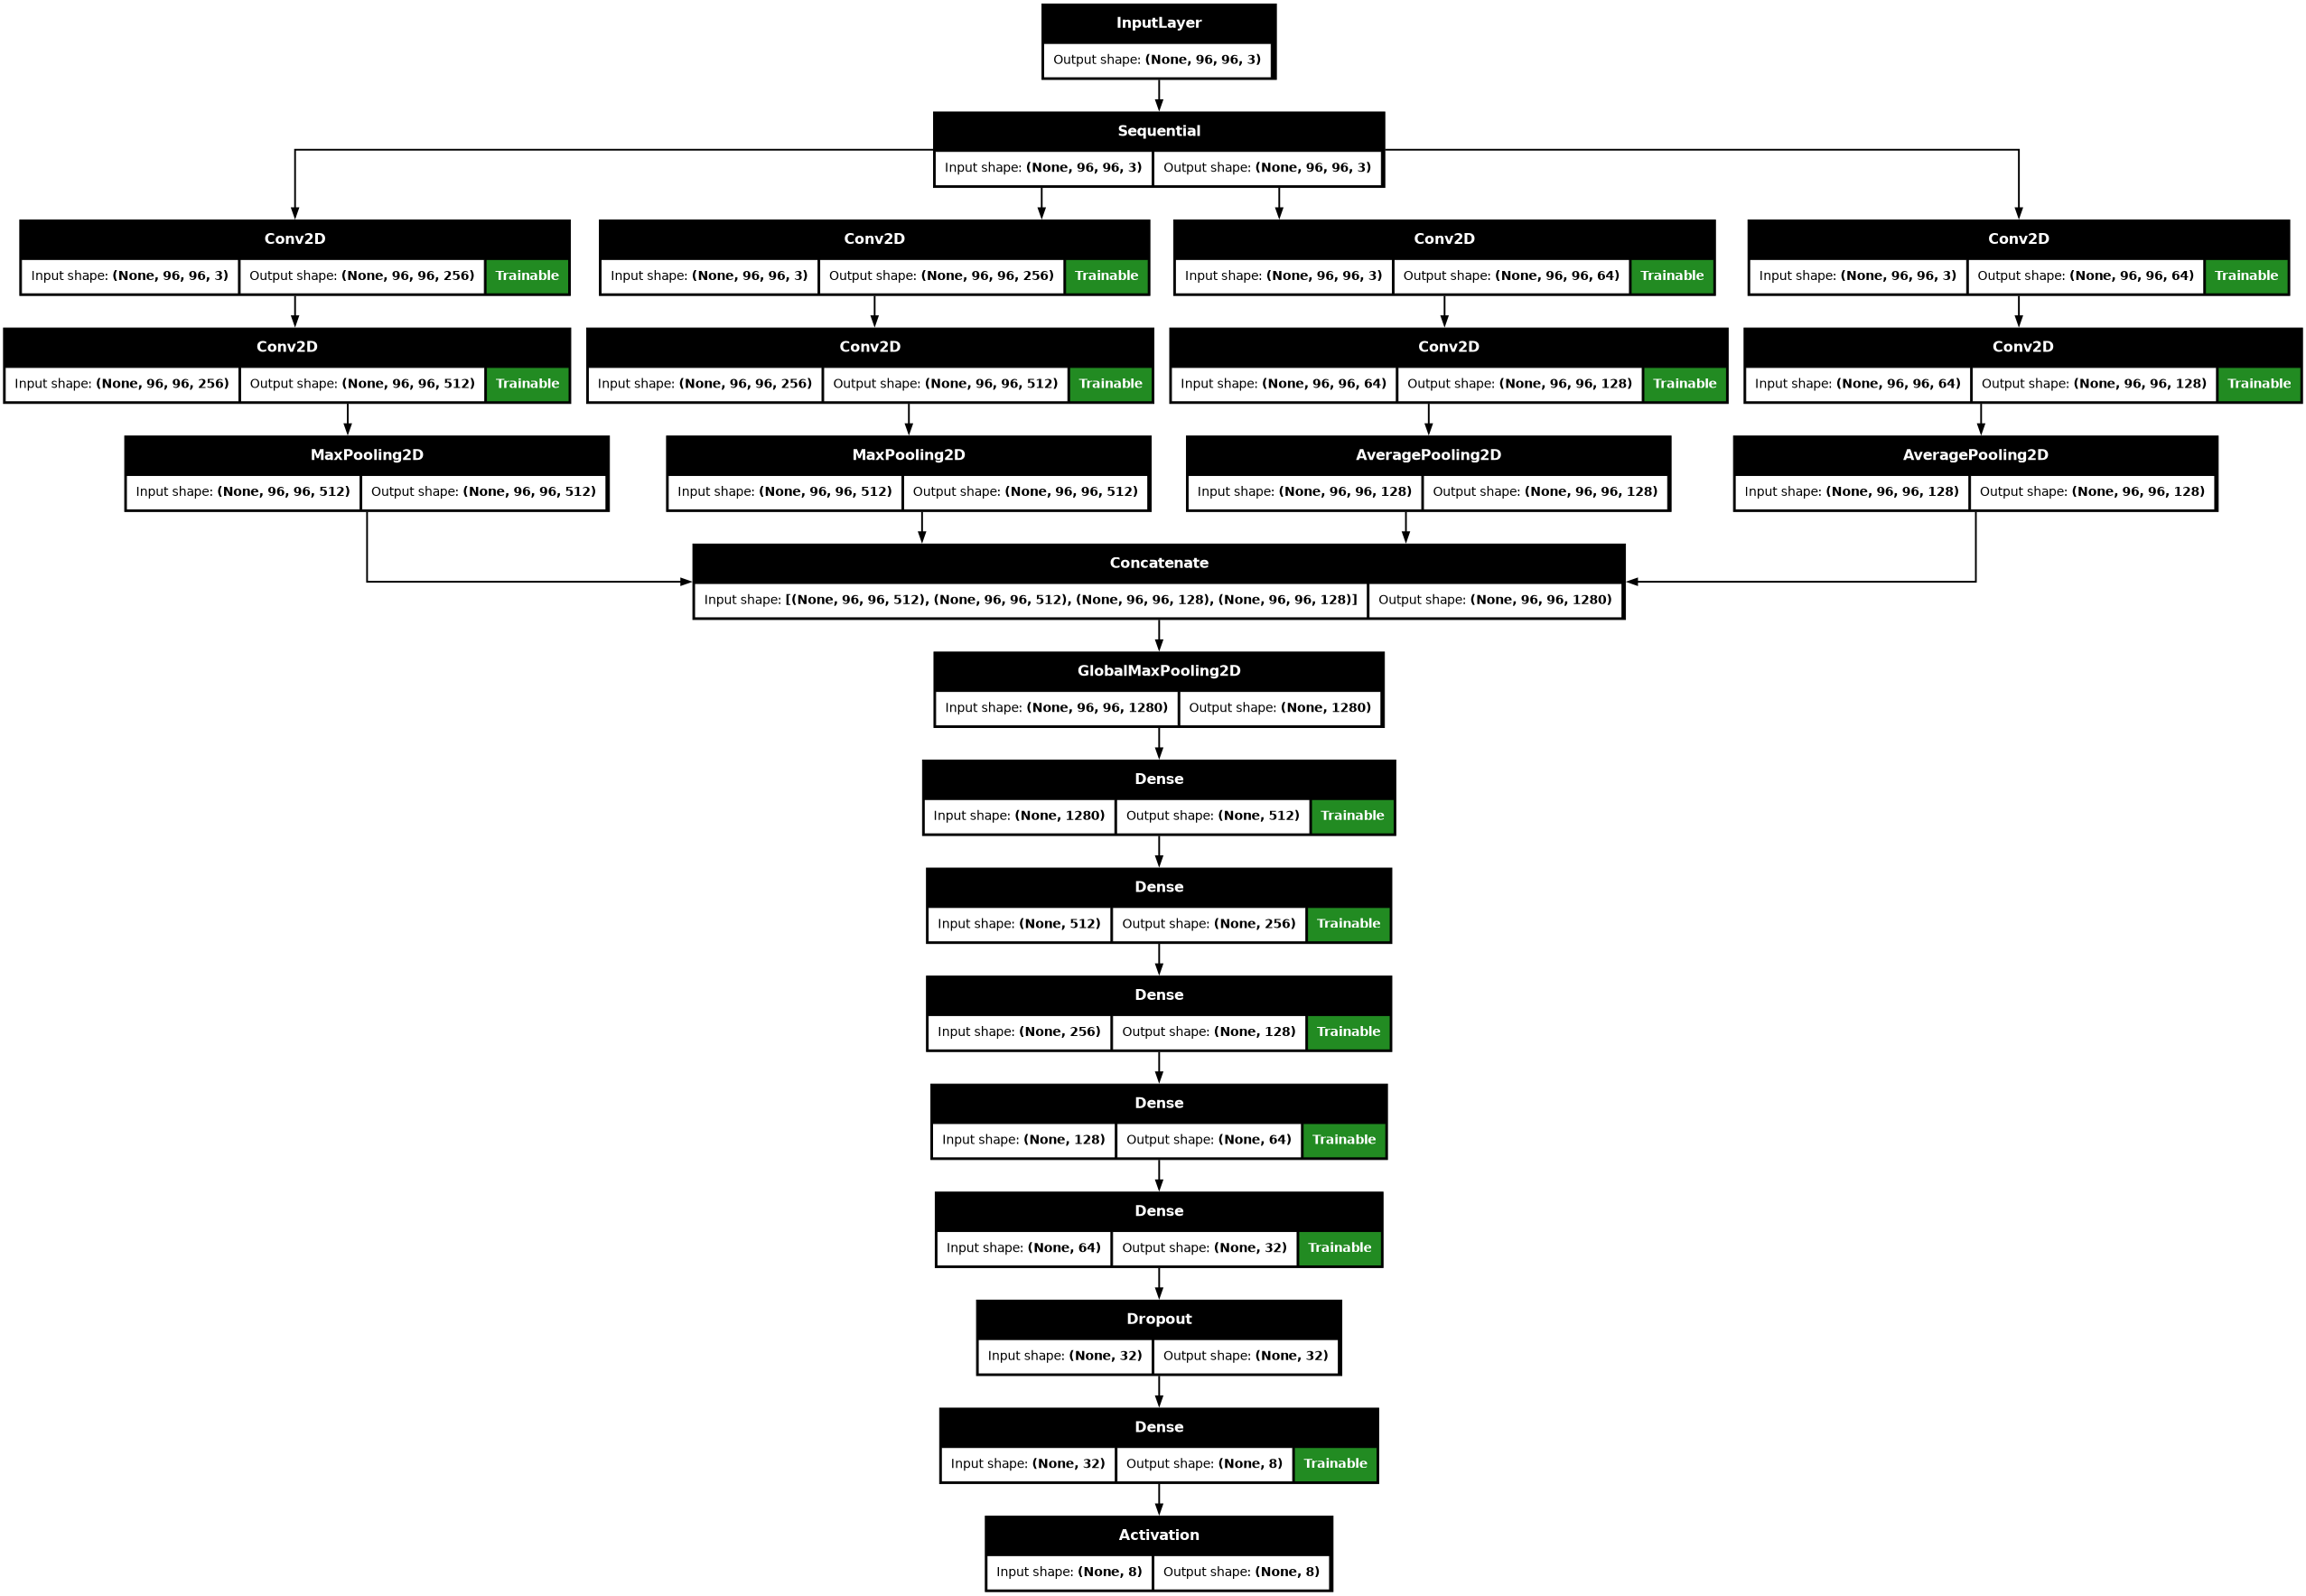

In [51]:
# Build the model with specified input and output shapes
model = build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        learning_rate=learning_rate,
        seed=seed
)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [52]:
# Train the model
history = model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # restore serve per il best model
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model.save('weights.keras')

# Free memory by deleting the model instance
del model

Epoch 1/300


ResourceExhaustedError: Graph execution error:

Detected at node CNN_1/concat2_1/concat defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_13182/2658200447.py", line 2, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/merging/base_merge.py", line 189, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/merging/concatenate.py", line 101, in _merge_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 1352, in concatenate

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 883, in concatenate

OOM when allocating tensor with shape[64,1280,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node CNN_1/concat2_1/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_52821]

In [ ]:
# 1 blocco di Inception con kernel a 1 - 23.13%
# alzo il kernel a 2 nel blocco - 32.37% ---------> kernel migliore, proviamo a combinarlo con un altro più grande
# alzo il kernel a 3 nel blocco - 17.48%
# alzo il kernel a 5 - 8.32 %
# alzo il kernel a 7 - 17.36%
# alzo il kernel a 11 - 17.77%

# KERNEL A 2 - 32.37%
# cambio i filtri da 32-64 a 64-128 - 18.99% torno indietro
# 2 blocchi di inception: uno a kernel 1 e uno a kernel 2 - 17,61%
# 2 blocchi di inception: uno a kernel 2 e uno a kernel 3 - 17,31%
# 2 blocchi di inception: uno a kernel 2 e uno a kernel 7 - 17.69%

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training loss', alpha=.8, linewidth=2)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, linewidth=2)
plt.title('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, linewidth=2)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, linewidth=2)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Con tre strati ho molti più picchi

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
import os
from datetime import datetime

# Definisci il nome del file di output con timestamp
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Crea una directory per il salvataggio del modello e dello script (se non esiste già)
output_dir = '/kaggle/working/'  # Directory di lavoro di Kaggle
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Aggiungi i file alla compressione zip
os.system(f'zip -r {output_dir}/{filename} model.py weights.keras')

# Ora il file .zip è pronto nella directory '/kaggle/working/'
print(f"File salvato come {output_dir}/{filename}")